# ML in Cybersecurity: Project I

## Team
  * **Team name**:  The Hidden Adversaries
  * **Members**:  Tomas Amado (toam00001@stud.uni-saarland.de), Deepanshu Mehta (deme00001@stud.uni-saarland.de), Marco Schuster (masc00008@stud.uni-saarland.de)


## Logistics
  * **Due date**: 29th November 2020, 23:59:59 (email the completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland)
  * Complete this in **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws2021_stud) to find group members.
  
## Timeline
  * 16-Nov-2020: Project 1 hand-out
  * **29-Nov-2020** (23:59:59): Email the completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland
  * 30-Nov-2020: Project 1 discussion and summary
  
  
## About this Project
In this project, you'll implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The dataset is based on a seminal [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), which immensely popularized (convolutional) neural networks. This is a great starting point for ML research and this dataset/model has been a stepping stone numerous other tasks such as [GANs](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), [Adversarial Perturbations](https://arxiv.org/abs/1412.6572) and so many more!

This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9. The notebook will guide you to load this data, implement classifiers $\hat{y_i} = f_w(x_i)$  and analyze results. By doing so, you'll have a ML model that works on real data!

To put things into context, have a look at Slide 21 in the [second](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf) lecture. Within this framework, the following blocks of this project are fixed:
  * *Real-world problem*: Digit classification
  * *Performance metric*: Mean accuracy i.e., $ \frac{1}{N} \sum_{i=1}^N \mathbb{1}[\hat{y_i} = y_i]$, where $\mathbb{1}[\hat{y_i} = y_i]$ is 1 if your model predicted the right digit for the $i$-th digit and 0 otherwise.
  * *Data*: The MNIST dataset

You'll make the the following design-choices:
 * *Choice of Model*: A model family (Non-parametric methods, Linear classifiers, Neural Networks, etc.)
 * *ML Model*: Specific model (e.g., SVM with a polynomial kernel)
 * *Loss/Risk*
 * *Optimization*


## A Note on Grading
The grading for this project will depend on:
 1. Functional digit classifier
   * Following a well-defined ML pipeline
   * Developing 3 classification models (keep them diverse and ideally of increasing complexity)
   * Obtaining reasonable accuracies (>80%) on a held-out test set
 1. Analysis
   * Which methods work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
    * Anything else you find interesting (this part is open-ended)
  
 A note on (1.): 
  * Choose your models that aids good insights. We require at least one non-Neural Network (e.g., SVM, KNN) and one Neural Network model (e.g., MLP, CNN).
  * We definitely don't expect all three models to achieve >99% test accuracies!

## Grading Details
 * 5 points for loading and visualization 
 * 25x3 points for models. Per model:
   * 4 points for written description 
   * 7 points for implementation
   * 7 points for evaluation
   * 7 points for summary
 * 15 points for final summary (Section 3)
 * 5 points for clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use final summary to provide report about these codes.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v2.0: Added pytorch
  * v1.1: Added Code of Honor
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

import torch
import torchvision
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torch import nn
# We only support sklearn and pytorch.

# Please set random seed to have reproduceable results, e.g. torch.manual_seed(123)
np.random.seed(42)
torch.manual_seed(42)


Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
def identity_func(foo):
    return foo

# wraps a separated dataset to avoid issues while shuffling
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.y)

# get the same batch split for inputs and labels
def get_batched_x_y(x, y, batch_size, shuffle):
    dataset = WrapperDataset(x, y)
    batched = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return batched

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.6, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.uint8)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()  

# 1. Loading and Visualizing data (5 points)

In this section, you'll need to prepare the MNIST data for the experiments you'll be conducting for the remainder of the notebook.

## 1.1. Load Data

Here you'll load the MNIST data into memory. The end-goal is to two have the following variables:
  * `x_trainval`, `x_test`: of shape $N \times d_1 \times d_2 \dots$ (e.g., $N \times 784$. 784 since you could flatten each 28x28 pixel image into a single vector)
  * `y_trainval`, `y_test`: of shape $N \times K$ (K = 1 or 10 depending on how you plan to represent the ground-truth digit annotation)

You can either do this by:
  1. Downloading the MNIST dataset, unpacking and preparing it yourself to have fine-grained control
  1. Using high-level existing functions, such as the one provided by  [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist).
  
  
  In either case, it is important that you have disjoint trainval and test splits!

In [4]:
# load the training set
training_set = torchvision.datasets.MNIST(root="", train=True, download=True)
x_trainval = torch.flatten(training_set.data, start_dim=1)
y_trainval = training_set.targets
# load the test set
test_set = torchvision.datasets.MNIST(root="", train=False, download=True)
x_test = torch.flatten(test_set.data, start_dim=1)
y_test = test_set.targets

# create 3d versions
x_trainval_3d = training_set.data
x_test_3d = test_set.data

print('x_trainval.shape = {},  x_trainval_3d.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, x_trainval_3d.shape, y_trainval.shape))
print('x_test.shape = {},  x_test_3d.shape = {}  y_test.shape = {}'.format(x_test.shape, x_test_3d.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 1.0
x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]
x_trainval_3d = x_trainval_3d[:int(len(x_trainval)*DEBUG_FRAC)]


x_trainval.shape = torch.Size([60000, 784]),  x_trainval_3d.shape = torch.Size([60000, 28, 28]),  y_trainval.shape = torch.Size([60000])
x_test.shape = torch.Size([10000, 784]),  x_test_3d.shape = torch.Size([10000, 28, 28])  y_test.shape = torch.Size([10000])


#### 1.2. Visualize Data

To get the hang of your data you'll be training a digit classifier on, visualize it.

Examples of ways to visualize it:
  * Given a digit, display few randomly sampled images for this digit (the bare minimum)
  * Visualize as a grid (e.g., Slide 4, [Lecture 2](https://cms.cispa.saarland/mlcysec19/dl/4/2019-10-24-ml.pdf)) using a combination of `plt.imshow` and `plt.subplots`
  
It's up to you to decide how you want to do this. The end-goal is for you to potentially give a trailer of the dataset to someone who hasn't seen it before.

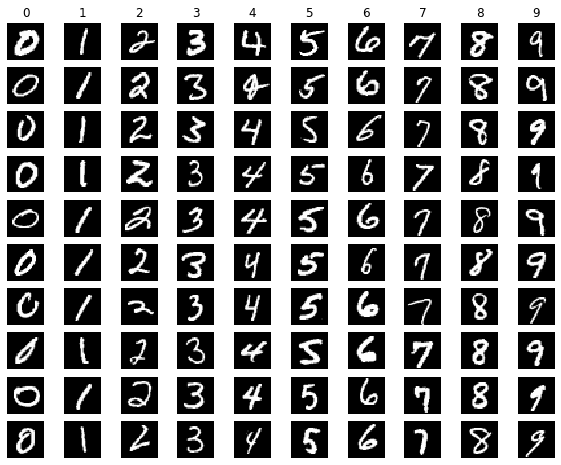

In [5]:
# Visualize 10 examples of 10 classes. You can extend the following code:
rows, cols = 10, 10
fig,ax = plt.subplots(nrows = rows, ncols = cols)

# loop through grid of plots
for i in range(rows):
    for j in range(cols):
        # only select samples that match the current digit
        numberSelection = y_trainval == j
        # show a random image of the digit without axes
        ax[i][j].imshow(x_trainval_3d[numberSelection][np.random.randint(0, np.count_nonzero(numberSelection))])
        ax[i][j].axis("off")
        # print the column title only for the first digit per column
        if i == 0:
            ax[i][j].set_title(str(j))

plt.savefig('fig1.pdf')   # Save the figures
plt.show()   # These should be some visualization of data at the end of this section

# You can see an output example in the follow:

# 2. Digit classifiers

In this section, you'll begin developing models to perform digit classification.

Each model needs to be structured like so:
  1. Give a brief reason which model you are going to train and why you choose it
  1. Define hyper-parameters for model and optimization procedure
  1. Define your model
  1. Define optimization method and fit model to data
  1. Summarize your findings







## 2.1: Model [M1]: k Nearest Neighbors (25 points)

Short description : As the simplest model we will train KNN. It is a simple non parametric algorithm that predicts the class of an input by the majority class of its k nearest neighbors. For simplicity the Euclidean distance is used to determine closeness.

### 2.1.1: Hyper-parameters

Define hyper-parameters for your model here

In [6]:

n_neighbors = [2, 3, 4, 5, 6, 8, 10]

test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    train_idxs, val_idxs = train_test_split(np.arange(x_trainval.shape[0]), test_size=1/6)
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test



### 2.1.2: Data Preprocessing


Scale dataset to zero mean and unit variance.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_eval = scaler.transform(x_eval)


### 2.1.3: Model Definition

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
classifier = KNeighborsClassifier(n_jobs=-1)

### 2.1.4: Fit Model

Define optimization procedure and fit your model to the data

In [10]:
scores = []

In [11]:
for i in n_neighbors:
    classifier = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    classifier.fit(x_train, y_train)
    scores.append(classifier.score(x_eval, y_eval))
    print(".", end="") # show progress

.......

In [12]:
scores

[0.9344, 0.9437, 0.9426, 0.9431, 0.9416, 0.9403, 0.9378]

### 2.1.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot the score (accuracy) for each model using "plot_scores" function
  * Report score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


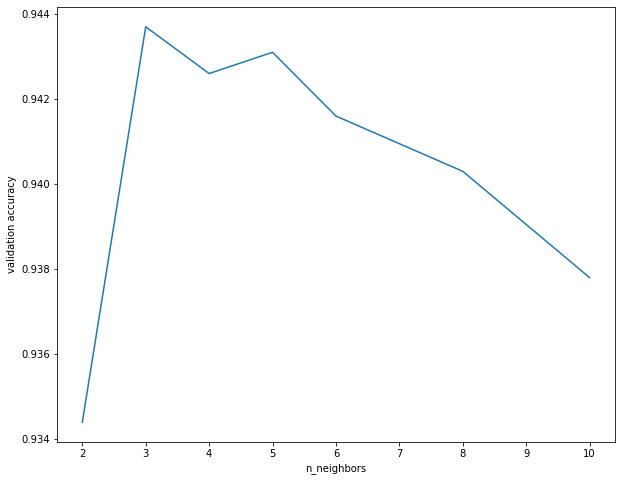

In [14]:
plt.plot(n_neighbors, scores)
plt.xlabel('n_neighbors')
plt.ylabel('validation accuracy')
plt.show()

The above plot shows that n_neighbors=3 leads to the best validation accuracy and should thus be chosen. The next cells were executed using the test instead of the validation set.

In [11]:
# Here report the score for the best model
classifier_best = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
classifier_best.fit(x_train, y_train)
print('Best model with n_neighbors=3 has a test accuracy of:',classifier_best.score(x_eval, y_eval))

Best model with n_neighbors=3 has a test accuracy of: 0.9452


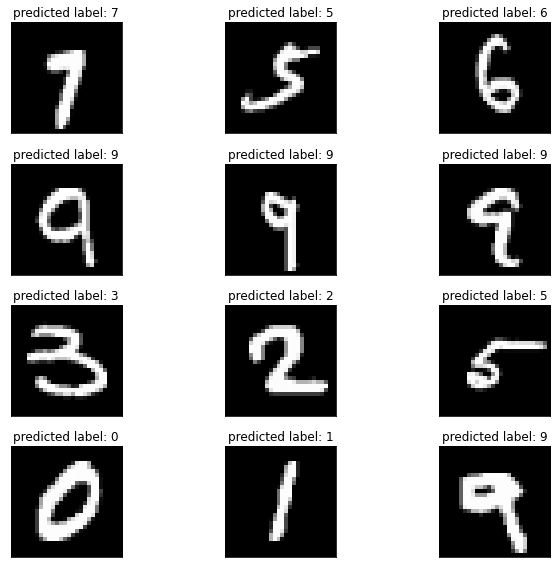

In [14]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
y_pred = classifier_best.predict(x_eval)
vis_predictions(scaler.inverse_transform(x_eval), y_pred, len(x_eval))


### 2.1.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

We saw that KNN is easy to understand and implement. Despite its simplicity it also achieved a pretty good results with a final test accuracy of 94.52%. The number of neighbors was basically the only hyperparameter to tune but it turned out that at least in the range [2, 10] the effects were rather minor (1% of validation accuracy). Another design choice was the distance metric which could have a significant effect as well. However, for simplicity and time this was not investigated. Besides that it took quite some computational time to evaluate/score this classifier. With 50,000 training and 10,000 validation samples scoring took several minutes on a 4-core CPU. This behaviour makes sense since KNN does not really build a model but rather searches all of its training samples for neighbors which is computationally expensive especially for large datasets.

# 2.2: Model [M2]: Logistic regression(25 points)




Since the problem to be solved is one of classification, we chose logistic regression as a basic supervised learning technique to be able to compare its results against the much more advanced CNN model. Since the last layer of a CNN hold similarities to logistic regression, we can compare the results of inputing 784 values into the model vs the filtered and dimensionally reduced values that go into the last layer of a CNN.

### 2.2.1: Hyper-parameters

Define hyper-parameters for your method here

In [6]:
cvalues = [0.01, 0.1, 1, 10]
max_iter = [10, 100, 1000]

# You don't need the following code, if you can use data from 2.1.1.

test_set = 'test'  #  or 'test'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    train_idxs, val_idxs = train_test_split(np.arange(x_trainval.shape[0]), test_size=1/6)
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.2.2: Data Preprocessing


We regularize the training and test data

In [7]:
x_train = x_train / torch.max(x_train)
x_eval = x_eval / torch.max(x_eval)

### 2.2.3: Model

Define your model here (all hyper-parameters in 2.1.1)


In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

### 2.2.4: Fit Model


In [32]:
results = []

In [33]:
for c in cvalues:
    row = []
    for m in max_iter:
        clf = LogisticRegression(max_iter = m, C = c)
        clf.fit(x_train, y_train)
        row.append(clf.score(x_eval, y_eval))
    results.append(row)

C:\Users\Tomas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tomas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [34]:
print(results)

[[0.8712, 0.9101, 0.9102], [0.8712, 0.9203, 0.9196], [0.8711, 0.9194, 0.9172], [0.8711, 0.919, 0.9129]]


### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


We tried different values for C, which is the inverse of regularization. Smaller values specify stronger regularization. The default value on the first training is C = 1.
We also tried different values for max_iter, which corresponds to the max number of iterations of the training. We did this in case stopping the training before it converges achieves better results

It seems that the model yielded better results when it failed to converge, with max_iter = 100 and with C = 0.1

This best score was 0.9203

We plot the accuracy of the models when changing the C values, taking the max_iterations where the models converge

In [8]:
results_cvalues = [result[-1] for result in results]

In [9]:
results_cvalues

[0.9102, 0.9196, 0.9172, 0.9129]

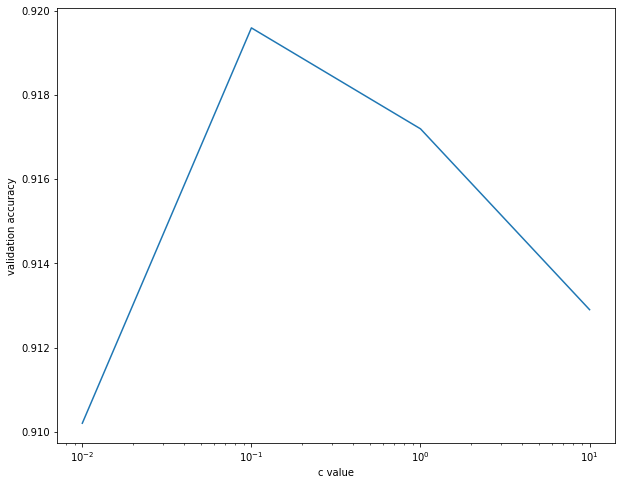

In [10]:
# Here plot epoch and accuracy over val/test set
plt.xscale('log')
plt.plot(cvalues, results_cvalues)
plt.xlabel("c value")
plt.ylabel("validation accuracy")
plt.show()

We can observe that the best value for C is 0.1

In [11]:
results_maxiter = results[cvalues.index(0.1)]

We then plot the results when changing the number of iterations with C = 0.1

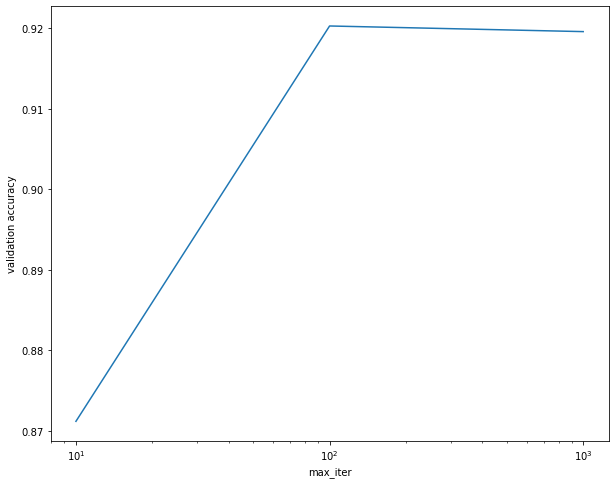

In [12]:
# Here plot epoch and accuracy over val/test set
plt.xscale('log')
plt.plot(max_iter, results_maxiter)
plt.xlabel("max_iter")
plt.ylabel("validation accuracy")
plt.show()

We can observe that when the model achieved better results when max_iter was 100 and the training did not converge. However, for max_iter=1000 the difference is barely noticeable.

We train using the test set instead of the validation set with the model corresponding to the best results from the hyperparameter search we did.

In [9]:
# Here report the score for the best model
clf = LogisticRegression(max_iter = 100, C = 0.1)
clf.fit(x_train, y_train)
clf_score = clf.score(x_eval, y_eval)
print('Best model with max_iter = 100, C = 0.1 has a test accuracy of:', clf_score)

Best model with max_iter = 100, C = 0.1 has a test accuracy of: 0.9256


C:\Users\Marco\.conda\envs\mlcysec\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We ended up with a final score of 0.9256 (92.56% mean accuracy) after using the test data

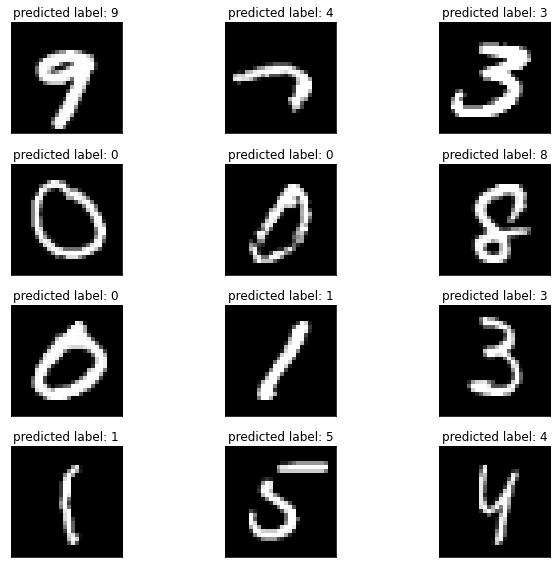

In [10]:
# Visualize the predictions
# Example: vis_predictions(x_eval, y_pred, size_of_data)
#
#
y_pred = clf.predict(x_eval)
vis_predictions(255 * x_eval.cpu().numpy(), y_pred, len(x_eval))

### 2.2.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

For the training of this logistic regression model we changed the C and max_iter hyper-parameters. The most important hyper-parameter appears to be max_iter since the score varied the most when changing this value. Especially when using a low max_iter value since it meant that the training was stopped far before it could converge. Generally the models performed better when they converged, but in this case, for the validation set, the best model was one where the model did not converge fully.

In terms of design choices, we used the L2 norm for penalization. There weren't any other specific design choices in the training, except for testing the hyper-parameters through a loop of changing both values instead of doing it manually. The sklearn library facilitates this process with the LogisticRegression() classifier.

# 2.3: Model [M3] (Neural Networks): Convolutional Neural Network (CNN) (25 points)



Since Convolutional Neural Networks (CNNs) are generally good at image recognition or more specifically extracting features from images a CNN will be used in the following as the most complex and advanced method. CNNs generally use multiple trainable Sobel filters which exploint the 2D structure of neighboring pixels which makes them so useful for images.

### 2.3.1: Hyper-parameters

Define hyper-parameters for your method here

In [ ]:
batch_size_train = 64
batch_size_test = 256
n_epochs = 6
learning_rate = 0.001
betas = (0.9, 0.999)


# You don't need the following code, if you can use data from 2.1.1.
# You can also use torch built-in functions (torch.utils.data)

test_set = 'test'  #  or 'val'
# Decide all your hyperparameters based on validation performance
# Then, switch to 'test' for final evaluation

if test_set == 'val':
    train_idxs, val_idxs = train_test_split(np.arange(x_trainval_3d.shape[0]), test_size=1/6)
    x_train, y_train = x_trainval_3d[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval_3d[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval_3d, y_trainval
    x_eval, y_eval = x_test_3d, y_test

### 2.3.2: Data Preprocessing


In [ ]:
# normalize inputs to interval [0, 1]
x_train = x_train / torch.max(x_train)
x_eval = x_eval / torch.max(x_eval)

print("x_train: min", torch.min(x_train), "max", torch.max(x_train))
print("x_eval: min", torch.min(x_eval), "max", torch.max(x_eval))

x_train: min tensor(0.) max tensor(1.)
x_eval: min tensor(0.) max tensor(1.)


### 2.3.3: Model

Define your model here

Several sources dealing with CNNs for the MNIST dataset were consulted to find an appropriate architecture. These were mostly [[1]](https://towardsdatascience.com/an-easy-introduction-to-pytorch-for-neural-networks-3ea08516bff2), [[2]](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/) and [[3]](https://ieeexplore.ieee.org/document/9213619). Similar to [3] two alternating convolutional and pooling layers were chosen to start with. However, significantly more channels (16 and 32 respectively) were chosen compared to [3]. Here the pooling layers are used to reduce the dimensionality. Within the network the ReLU activation function was used since it avoids vanishing gradients and thus is a best practise according to [2]. Furthermore the two fully connected layers at the end of the network were inspired by [2] as well. The softmax activation function was chosen for the output layer since it results in probabilities that the network outputs for each of the possible digits.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, (3,3))
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(16, 16, (3,3))
        self.pool2 = nn.MaxPool2d((2,2))
        self.linear1 = nn.Linear(400, 64)
        self.linear2 = nn.Linear(64, 10)

    def forward(self, x):
        relu = nn.ReLU()
        softmax = nn.Softmax(dim=1)
        result = relu(self.conv1(x))
        result = self.pool1(result)

        result = relu(self.conv2(result))
        result = self.pool2(result)

        # flatten convolutional output
        result = result.view(-1, 400)

        result = relu(self.linear1(result))
        result = softmax(self.linear2(result))

        return result


### 2.2.4: Fit Model


In [ ]:
# specify device depending on availability of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# create model and move it to the device
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
def train(x, y, x_eval, y_eval, model, epochs, batch_size, loss_function, optimizer):
    accuracies = []
    losses = []
    for epoch in range(epochs):
        # take record of current performance
        _, loss = test(x, y, model, 256, loss_function)
        accuracy, _ = test(x_eval, y_eval, model, 256, loss_function)
        print("Test Accuracy:", accuracy, "Training Loss:", loss)
        accuracies.append(accuracy)
        losses.append(loss)
        # shuffle and batch the data set
        batched = get_batched_x_y(x, y, batch_size, True)
        for xi, yi in batched:
            # add channel dimension to xi (only one grayscale channel)
            xi = torch.unsqueeze(xi, 1)
            # move data to device
            xi = xi.to(device)
            yi = yi.to(device)
            # reset previous gradients
            optimizer.zero_grad()
            # forward pass through CNN
            output = model(xi)
            # calculate current loss of CNN
            loss = loss_function(output, yi)
            # backprop
            loss.backward()
            # take optimization step
            optimizer.step()
    return accuracies, losses


In [ ]:
def test(x, y, model, batch_size, loss_function):
    averageLoss = 0.0
    averageAccuracy = 0.0
    numBatches = 0
    # batch the data set
    batched = get_batched_x_y(x, y, batch_size, False)
    for xi, yi in batched:
        # add channel dimension to xi (only one grayscale channel)
        xi = torch.unsqueeze(xi, 1)
        # move data to device
        xi = xi.to(device)
        yi = yi.to(device)
        # forward pass through CNN
        output = model(xi)
        # calculate current loss of CNN
        loss = loss_function(output, yi)
        # calculate accuracy
        predicted = torch.argmax(output, 1)
        matches = yi == predicted
        accuracy = matches.sum() / batch_size
        # record all values
        averageAccuracy += accuracy.item()
        averageLoss += loss.item()
        numBatches += 1
    averageAccuracy /= numBatches
    averageLoss /= numBatches
    return averageAccuracy, averageLoss

In the following a Adam optimizer is used since it takes a lot of information about the loss landscape into account to adjust the learning rate. In particular, it uses an exponential moving averages of the past gradients and square gradients. This makes it a good optimizer for most problems.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=betas)
accuracies, losses = train(x_train, y_train, x_eval, y_eval, model, n_epochs, batch_size_train, nn.CrossEntropyLoss(), optimizer)
test_accuracy, test_loss = test(x_eval, y_eval, model, batch_size_test, nn.CrossEntropyLoss())
# Save your model using torch.save()
torch.save(model, "model.pt")

Test Accuracy: 0.0986328125 Training Loss: 2.302838408693354
Test Accuracy: 0.84541015625 Training Loss: 1.6011105177250313
Test Accuracy: 0.86103515625 Training Loss: 1.5838572978973389
Test Accuracy: 0.94541015625 Training Loss: 1.496523435065087
Test Accuracy: 0.956640625 Training Loss: 1.4834284523700145
Test Accuracy: 0.96064453125 Training Loss: 1.4778185844421388


### 2.2.5: Evaluation

Evaluate your model.

  * Loss curves: Plot epoch (# passes over training data) and loss
  * Accuracy curves: Plot epoch and accuracy over val/test set
  * Final numbers: Report final accuracy numbers for your model

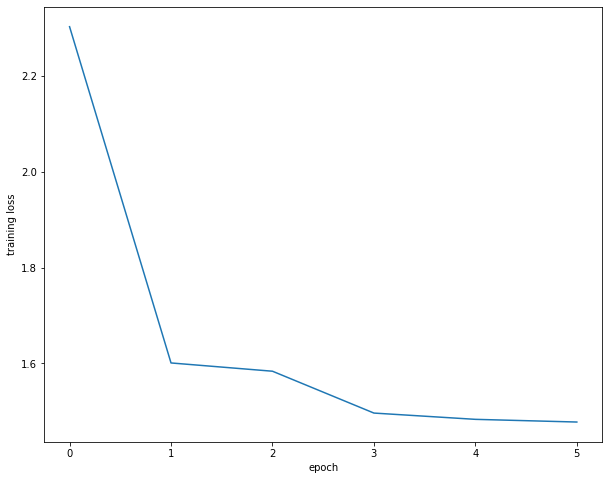

In [ ]:
# Here plot epoch (# passes over training data) and loss
plt.plot(range(len(losses)), losses)
plt.xlabel("epoch")
plt.ylabel("training loss")
plt.show()

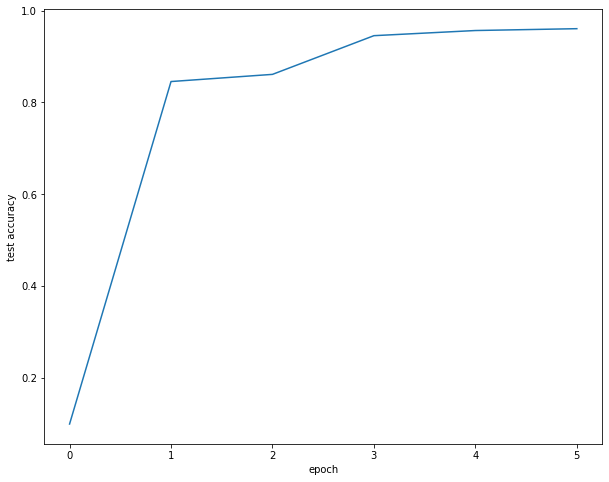

In [ ]:
# Here plot epoch and accuracy over val/test set
plt.plot(range(len(accuracies)), accuracies)
plt.xlabel("epoch")
plt.ylabel("test accuracy")
plt.show()

In [ ]:
# Here report the score for the best model
print("Final accuracy:", test_accuracy)

Final accuracy: 0.95986328125


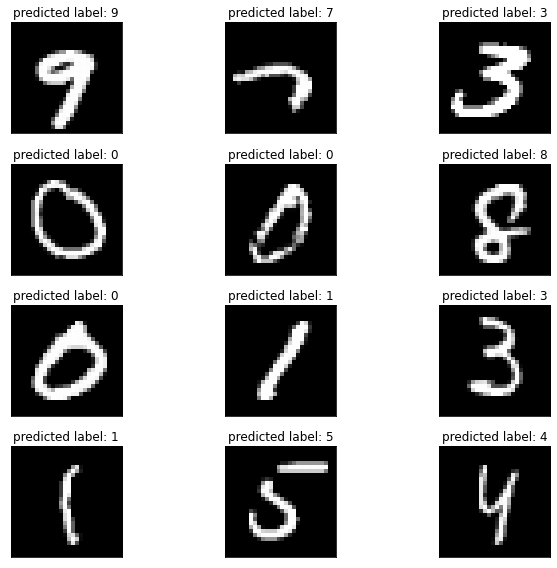

In [ ]:
# predict digits using the model
def predict(x, model):
    # add channel dimension
    myX = torch.unsqueeze(x, 1)
    # move data to GPU
    myX = myX.to(device)
    # get CNN output
    output = model(myX)
    # extract predictions as largest activation
    predictions = torch.argmax(output, 1)
    return predictions.cpu().numpy()

# Visualize the predictions
# get prediction labels
y_pred = predict(x_eval, model)
# restore original input range [0, 255] and convert to numpy array
# then visualize
vis_predictions(255 * x_eval.cpu().numpy(), y_pred, len(x_eval))

### 2.3.6: Summary

Summarize your findings:
 * Which hyper-parameters were important and how did they influence your results?
 * What were other design choices you faced?
 * Any other interesting insights...

The following test cases in terms of hyper-parameters were conducted. Each of these was executed on its own (i.e. keeping all other hyper-parameters at their final value). Thus only individual but no interaction effects could be observed.

| Test case | Value | Observation |
|:--------- | -----:| -----------:|
| many epochs | >20 | slight overfitting (2% accuracy difference) |
| large batch_size_train | 256 | slow convergence |
| large learning_rate | 0.1 | divergence |
| small learning_rate | 0.0001 | worse performance (accuracy 84 %) |
| very small betas | (0.2, 0.3) | little slower convergence |

The most important hyperparameters were clearly the learning rate and the batch size since both drastically impacted the training or the overall performance. The betas only had a very slight effect after a very significant change. This is similar for the epochs, however, it might be possible to reduce the overfitting effects through dropout layers or an early stopping mechanism. Also, the batch size for testing only had an effect on the speed of computation and was thus of low importance.

Besides the hyperparameters there were design choices regarding the architecture of the network, the loss function and the optimizer. Among these the last two were pretty straightforward since best practices could be followed and other choices for these would probably not have improved the result. The most interesting design choice was about the network's architecture. While the activation functions are also best practices the arrangement and sizes of layers seemed a little arbitrary. Still, these were partly based on research and tutorials but the most significant performance improvement probably lies in this design choice.

A very implementation-oriented insight was that it is a bad idea to split the training set into two tensors x and y when using the DatasetLoader for batching and shuffling the data. This was the case in earlier versions of this task and lead to basically no decrease in the loss since the batched dataset was basically completely random (i.e. images and labels did not match).

# 3. Summary (20 points)

Enter your final summary here.

You should now compare performance  on the three models [M1], [M2] and [M3]. Present this in a tabular format and/or using plots.

Which model do you recommend to perform digit classification and why?

Feel free to discuss other insightful observations.

The following table shows the final performance of the investigated models:

| Model Code | Model Name | Final test accuracy |
| ---------- | ---------- | ------------------- |
| M1 | k Nearest Neighbors | 94.52% |
| M2 | Logistic Regression | 92.56% |
| M3 | Convolutional Neural Network | 95.98% |


The Convolutional Neural Network was the best model in terms of accuracy. However it required the most design choices and the most research, since in comparison to the other models we needed to design its whole architecture. We have to keep in mind that our CNN was very simple and shallow in its architecture with just 6 layers. With investing more effort into its design it also has the most potential to achieve even better results. Due to the design efforts we would recommend this model to the experienced data scientists only. 

The k Nearest Neighbors model had the second best final test accuracy, just roughly 1.5% behind the CNN, which we found surprising due to the simplicity of the algorithm. Further, in comparison to the CNN it was easy to implement thanks to the Sklearn library. Nevertheless, for the predictions, the model took a lot of processing time to produce results due to the large datesets. We would recommend this model mostly for smaller datasets, unless the prediction performance is not important.

The Logistic Regression model had the worst final test accuracy. This is probably due to its purely linear weighting, which is too simple for image data. Still in comparison to kNN it could quickly predict, although it was a little slower in training. If a simple model is needed and prediction time is important, we would recommend this model.

To conclude we can say that all of the models had a good accuracy score (>90%), but our insights are limited only to this dataset. Thus our findings can't be used to generally make claims about model suitability.